# Install detectron2

In [1]:
!pip install -U torch torchvision > /dev/null
!pip install git+https://github.com/facebookresearch/fvcore.git > /dev/null
import torch, torchvision
torch.__version__

  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-4ep8jx5r


'1.11.0+cu113'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo > /dev/null
!pip install -e detectron2_repo > /dev/null

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14392, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 14392 (delta 58), reused 138 (delta 53), pack-reused 14227
Receiving objects: 100% (14392/14392), 5.95 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (10359/10359), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 151 kB 29.2 MB/s 
     |████████████████████████████████| 1.4 MB 64.2 MB/s 
     |████████████████████████████████| 431 kB 65.0 MB/s 
     |████████████████████████████████| 248 kB 66.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9

In [1]:
# RESTART the kernel before you go on

!rm -rf data.zip* trainable metadata.json __MACOSX
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [2]:
!ls

detectron2_repo  output  sample_data


In [3]:
# download, decompress the data
!wget https://github.com/BiEchi/ZJU_Sports_Punchclock/raw/main/trainable.zip -O trainable.zip > /dev/null
!unzip trainable.zip > /dev/null
!rm trainable.zip* > /dev/null

--2022-06-28 05:00:00--  https://github.com/BiEchi/ZJU_Sports_Punchclock/raw/main/trainable.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BiEchi/ZJU_Sports_Punchclock/main/trainable.zip [following]
--2022-06-28 05:00:01--  https://raw.githubusercontent.com/BiEchi/ZJU_Sports_Punchclock/main/trainable.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5104185 (4.9M) [application/zip]
Saving to: ‘trainable.zip’

trainable.zip       100%[===================>]   4.87M  --.-KB/s    in 0.08s   

2022-06-28 05:00:01 (58.5 MB/s) - ‘trainable.zip’ saved [5104185/5104185]



## Dataset Registration

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepbrick", {}, "./trainable/train/train_set.json", "./trainable/train")

In [6]:
train_metadata = MetadataCatalog.get("deepbrick")
train_dataset = DatasetCatalog.get("deepbrick")

WARNING [06/28 05:00:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 05:00:10 d2.data.datasets.coco]: Loaded 43 images in COCO format from ./trainable/train/train_set.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



./trainable/train/12_45.jpg


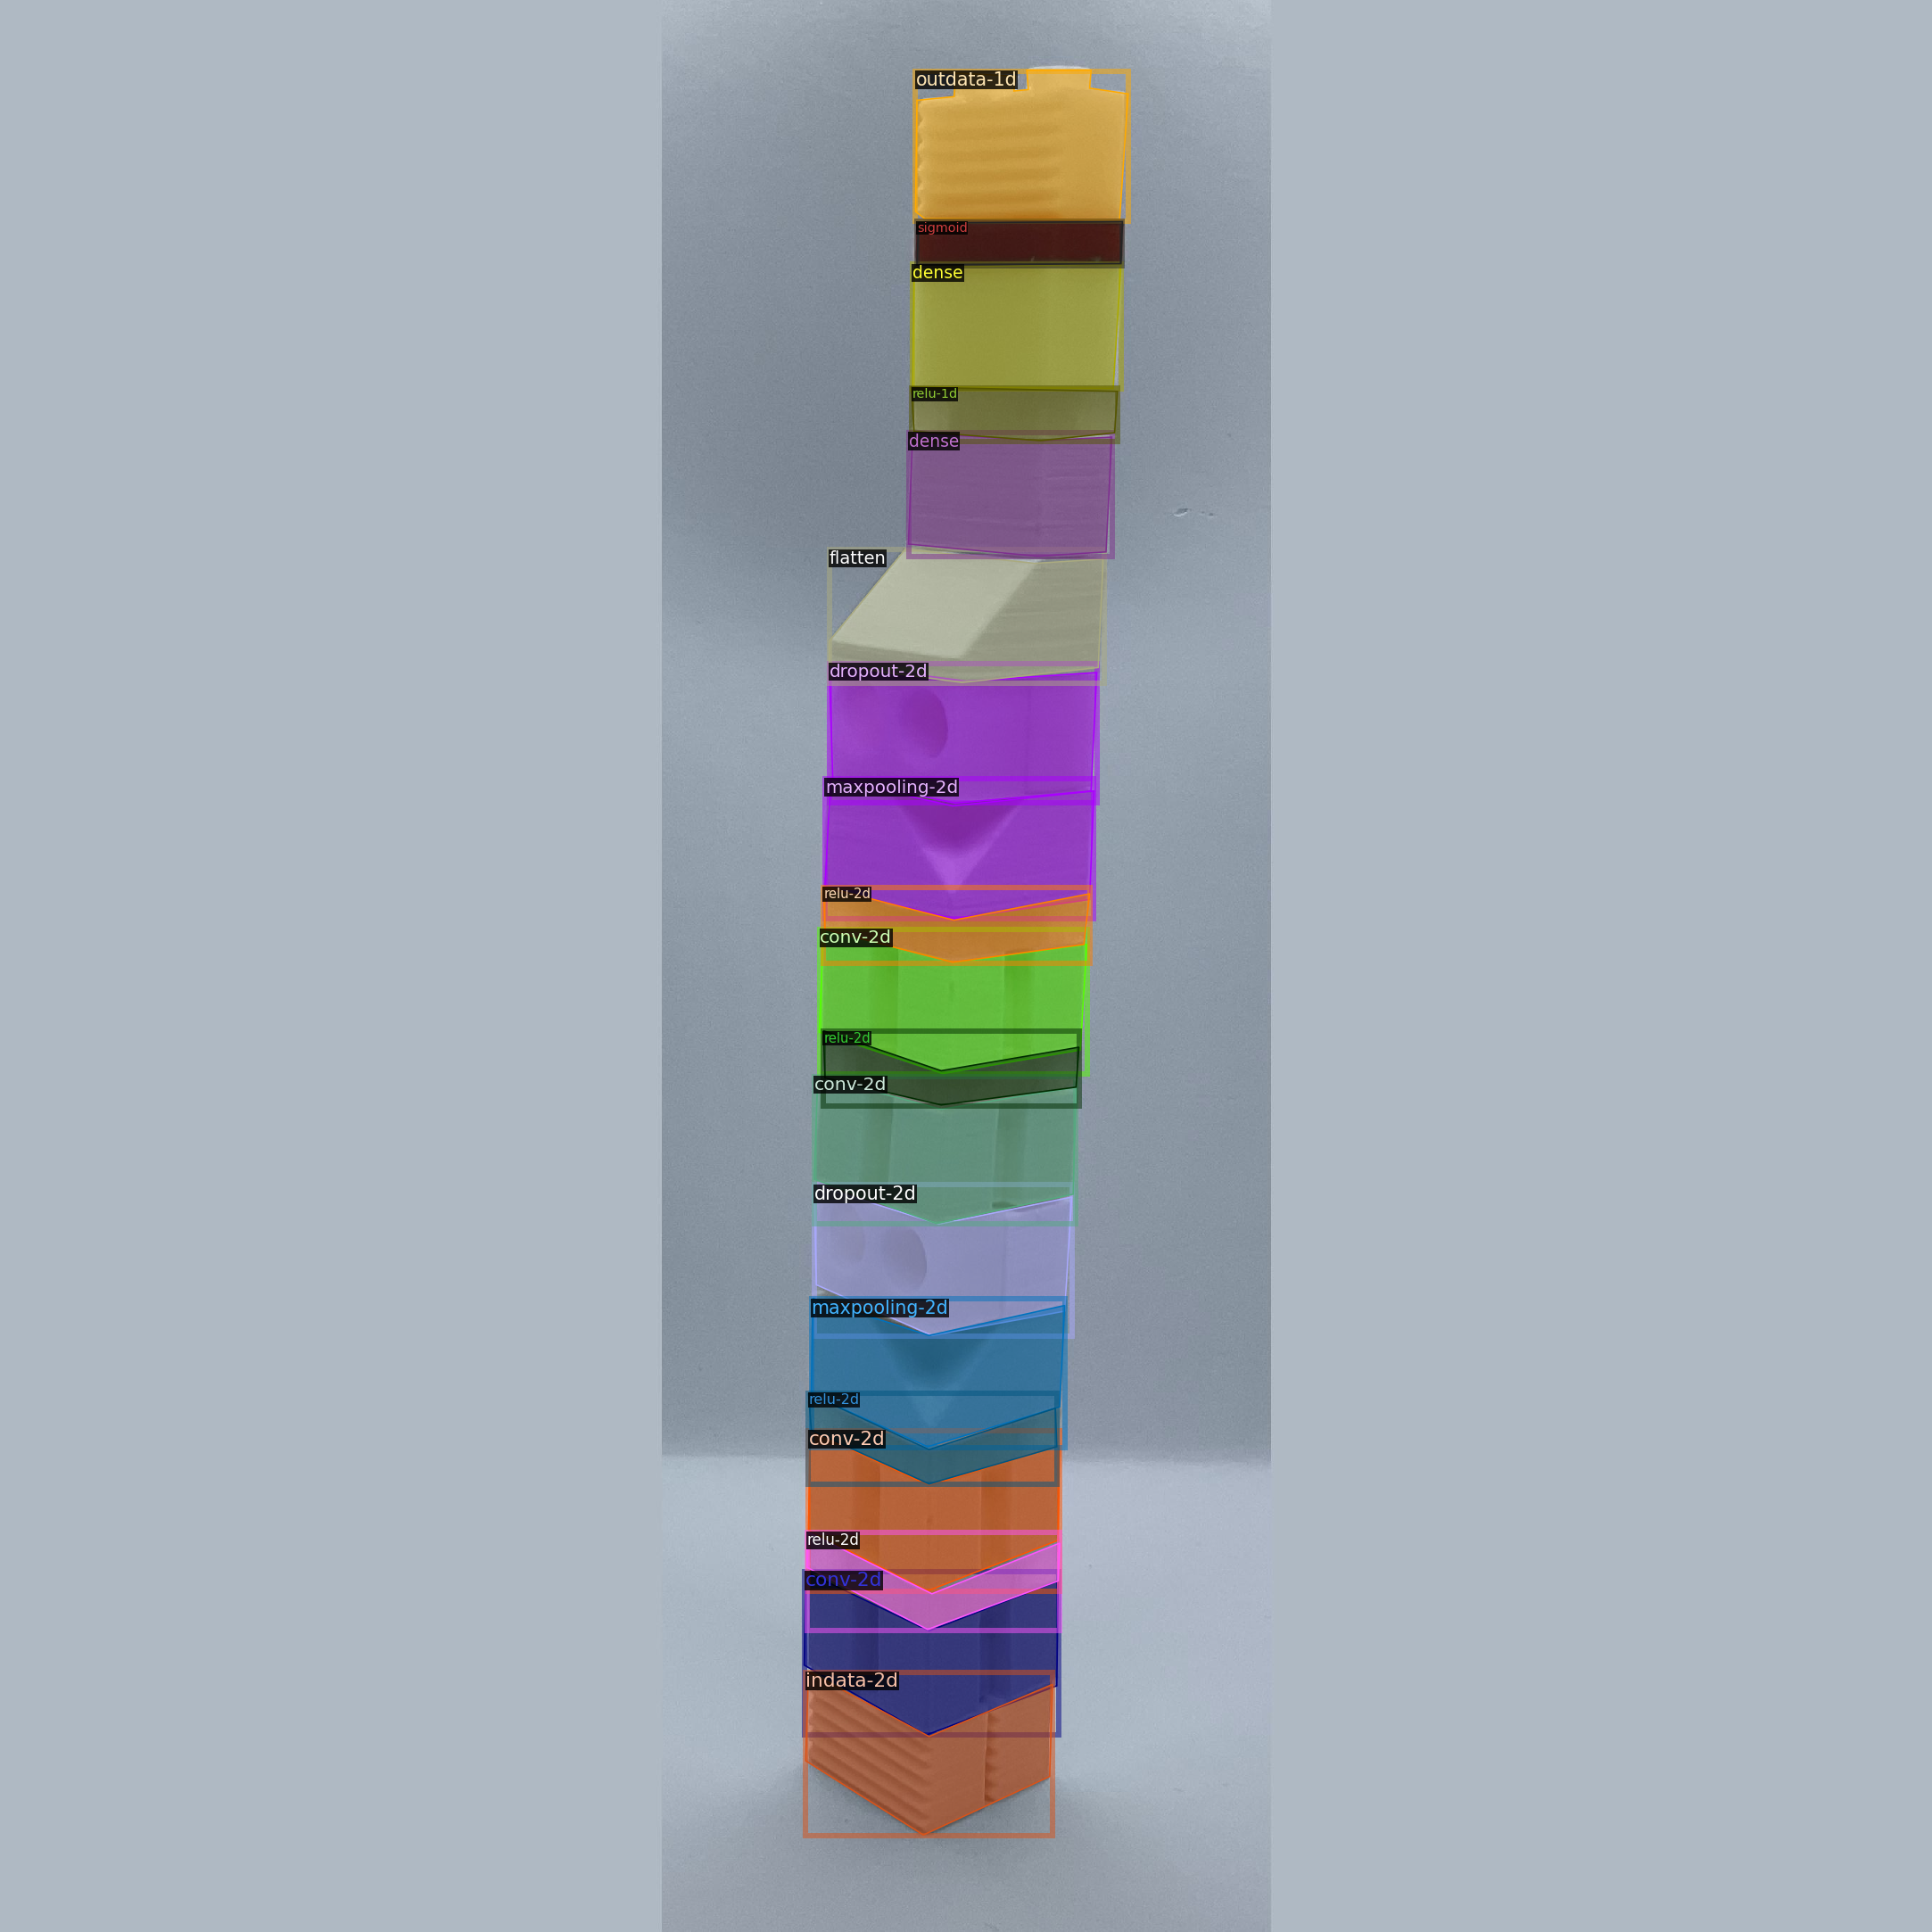

./trainable/train/5_45.jpg


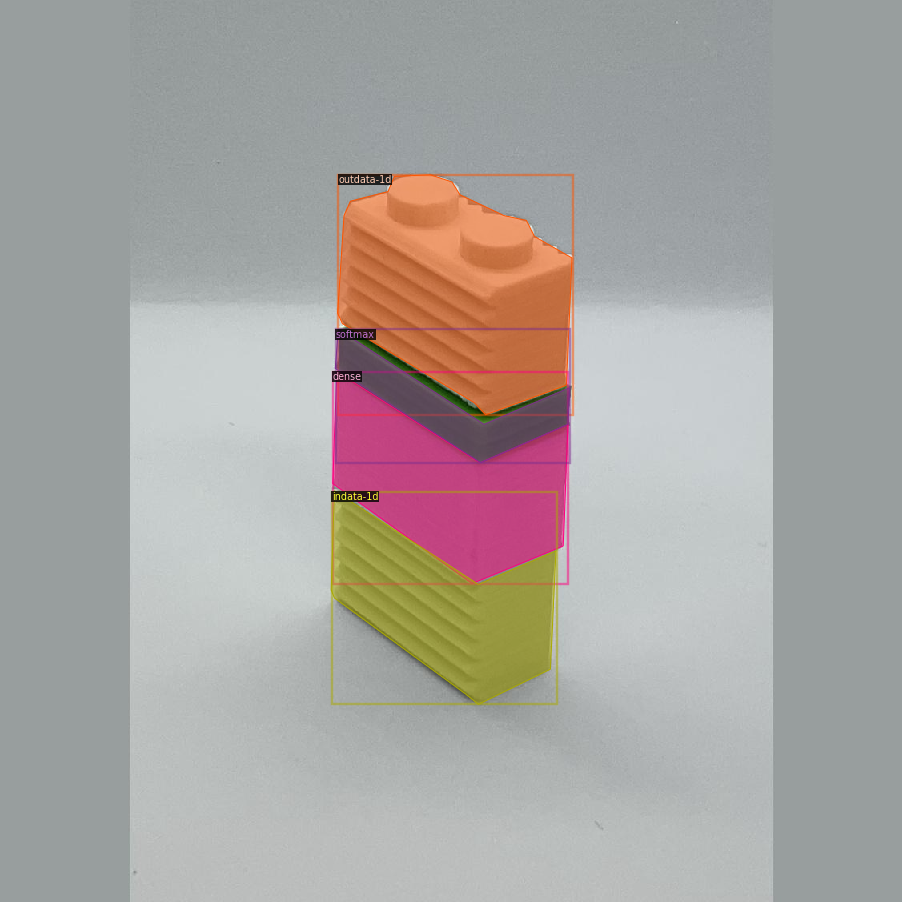

./trainable/train/4_45.jpg


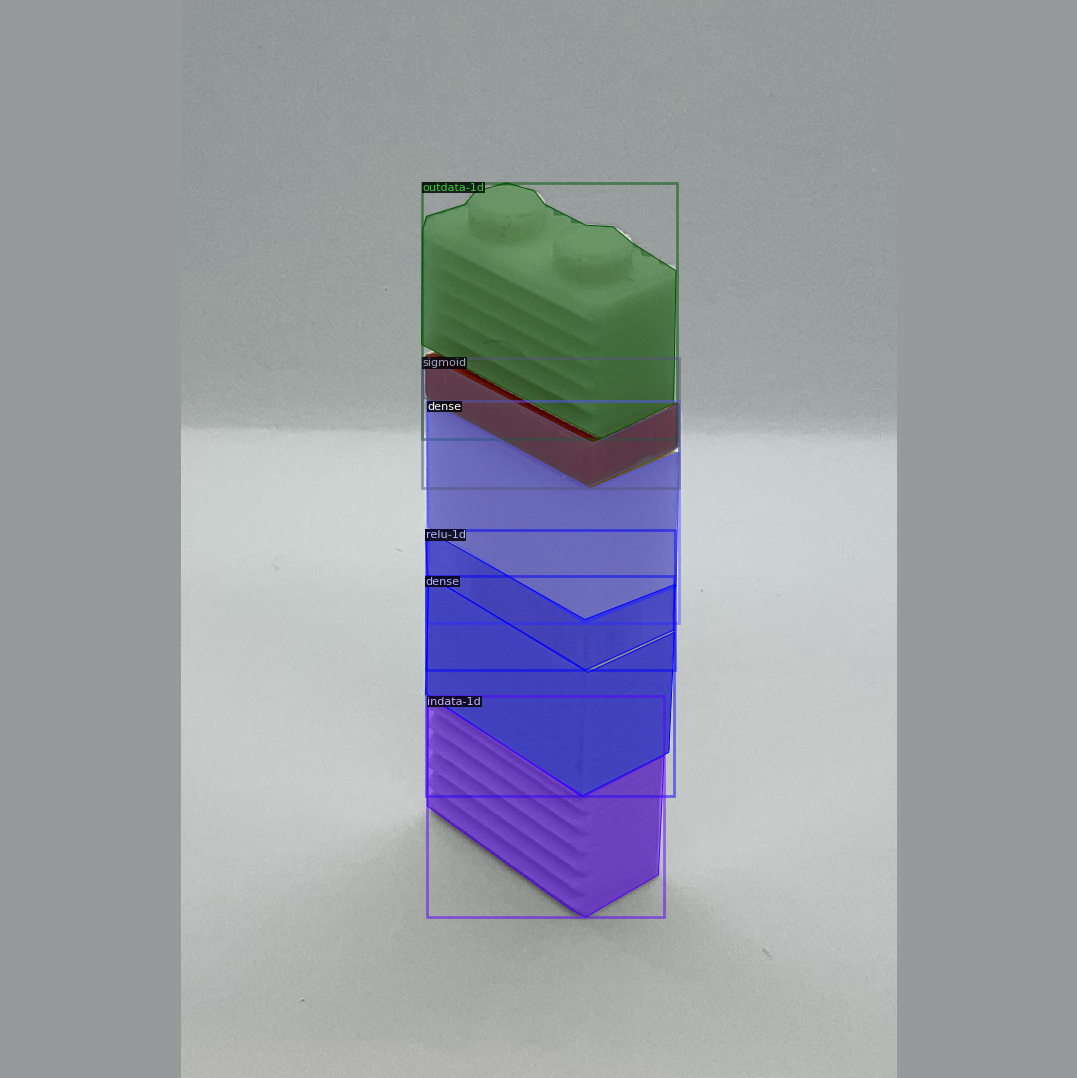

In [8]:
import random

for d in random.sample(train_dataset, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("deepbrick",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 500    # 300~1000 iterations are good
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # 11 classes (1 to 11)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/28 05:04:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (14, 256, 1, 

[06/28 05:04:54 d2.engine.train_loop]: Starting training from iteration 0
[06/28 05:04:58 d2.engine.hooks]: Overall training speed: 2 iterations in 0:00:01 (0.7066 s / it)
[06/28 05:04:58 d2.engine.hooks]: Total training time: 0:00:01 (0:00:00 on hooks)
[06/28 05:04:58 d2.utils.events]:  eta: 0:03:52  iter: 4  total_loss: 4.976  loss_cls: 2.602  loss_box_reg: 0.8999  loss_mask: 0.6923  loss_rpn_cls: 0.7211  loss_rpn_loc: 0.06126  time: 0.4692  data_time: 0.1771  lr: 0.00013988  max_mem: 1914M


KeyboardInterrupt: ignored

# Inferencing

## Inferencing on the trained data

Firstly, we infer on the training dataset.

In [24]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepbrick", )
predictor = DefaultPredictor(cfg)

[06/28 05:09:48 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

./trainable/test/1_15.jpg


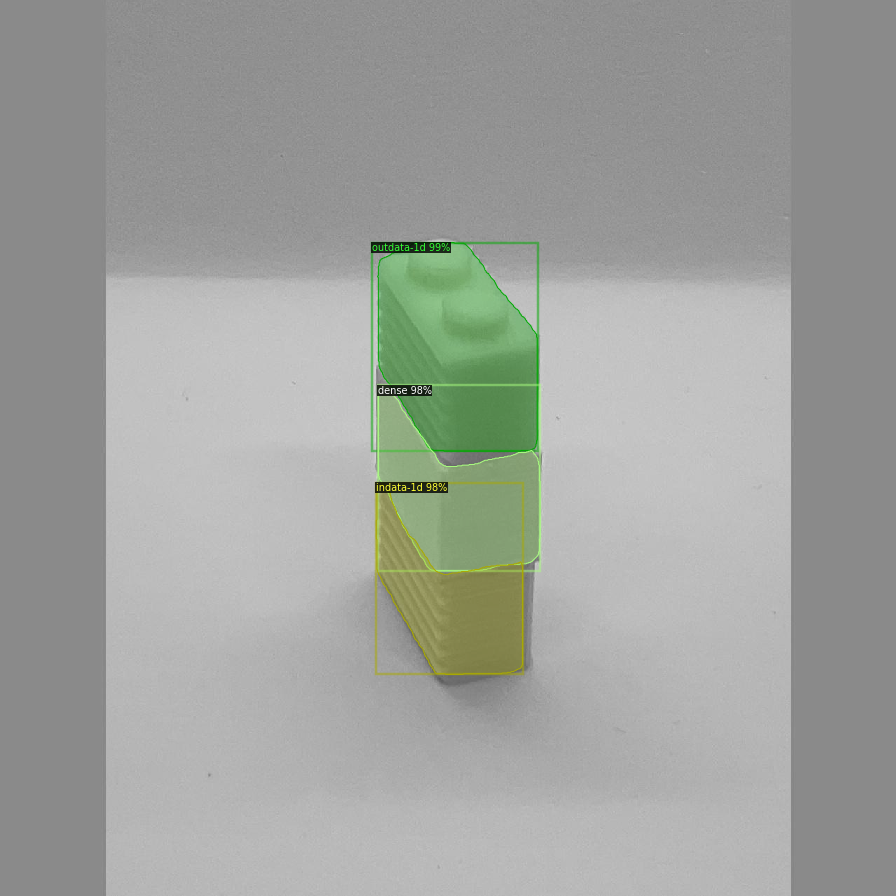

./trainable/test/16_75.jpg


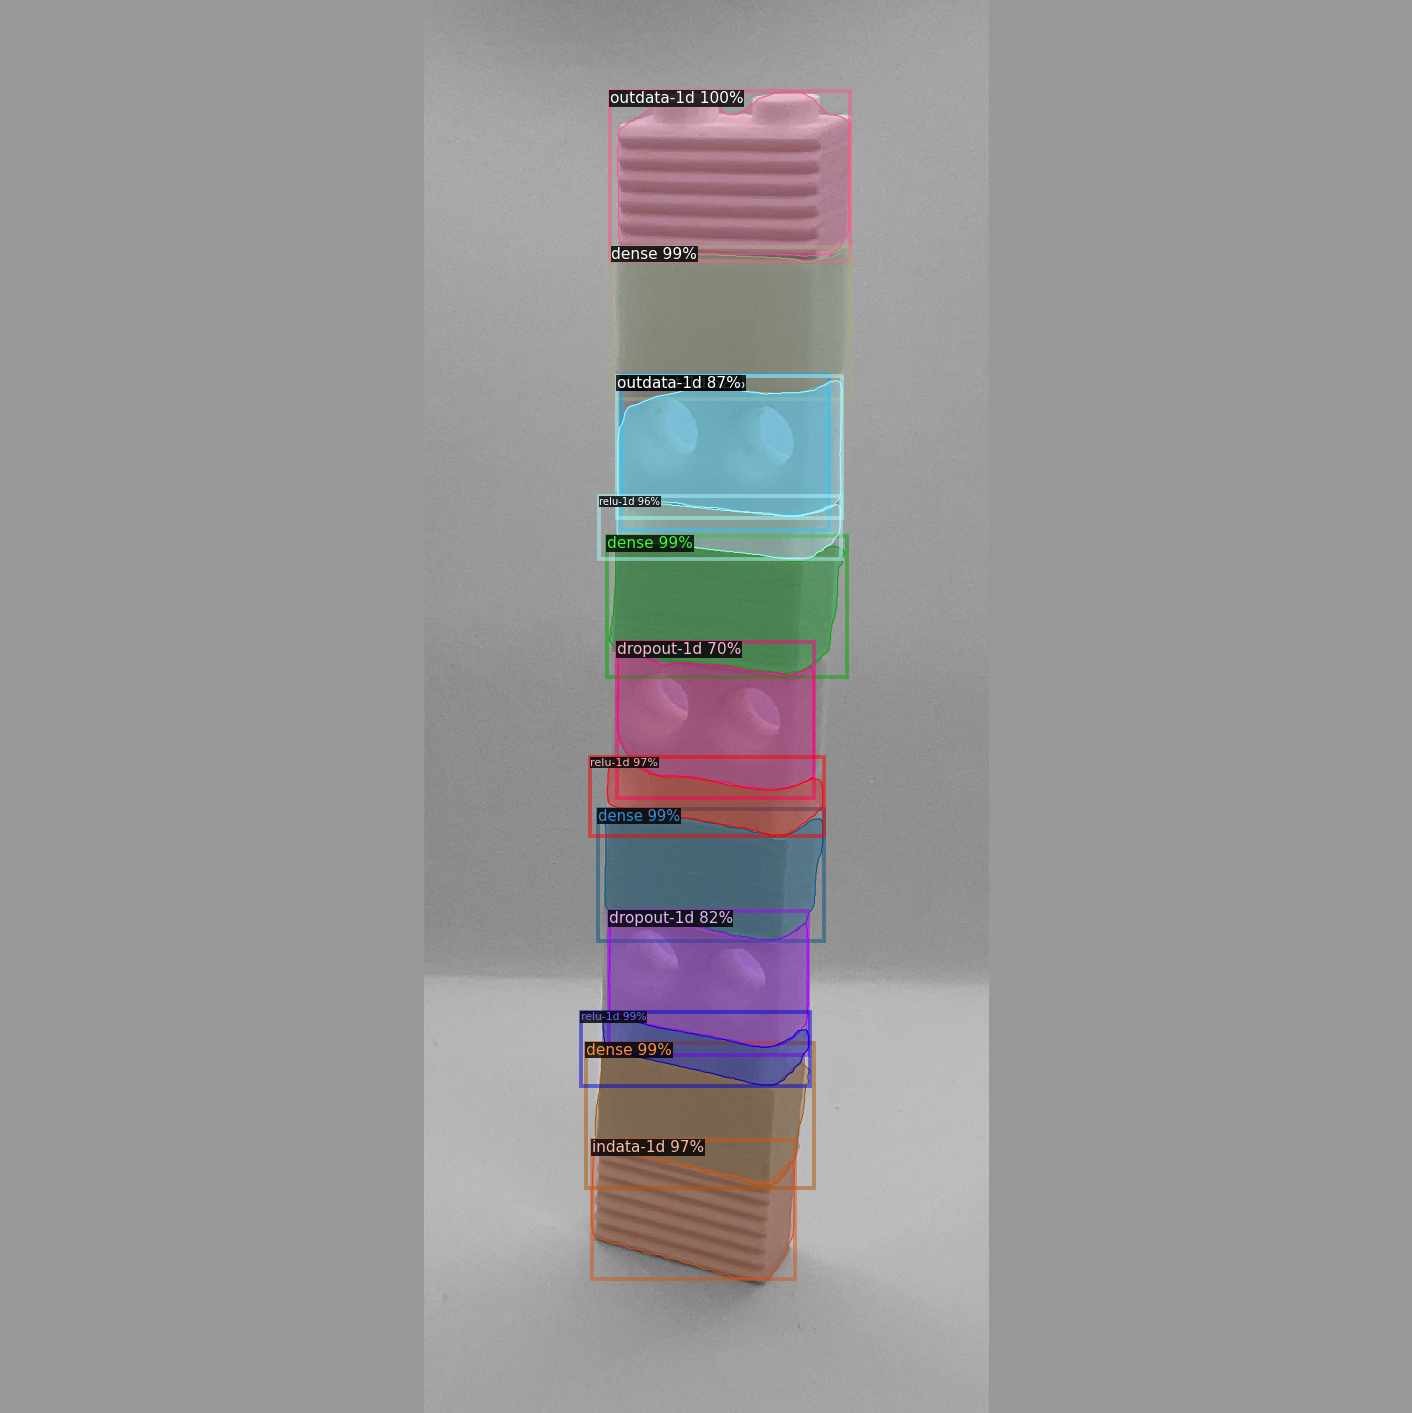

./trainable/test/11_75.jpg


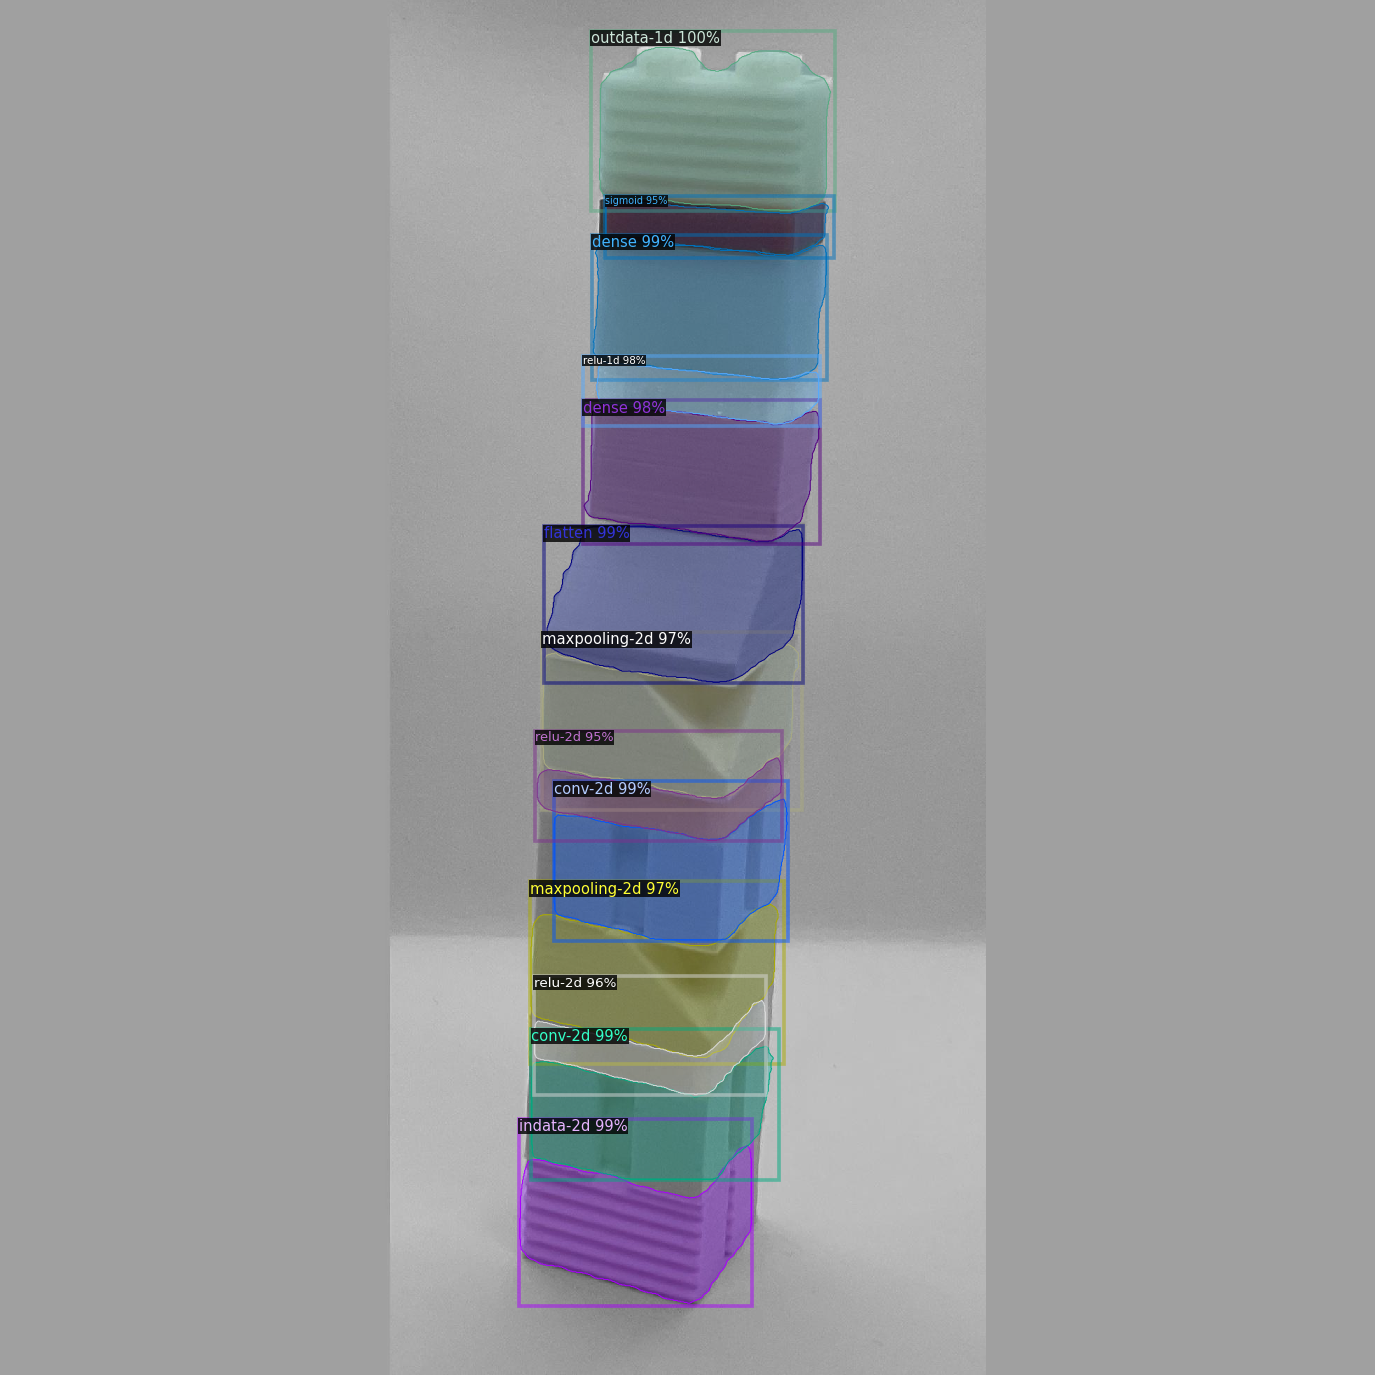

In [26]:
from detectron2.utils.visualizer import ColorMode
# use validation images to get predictions inference
for d in random.sample(train_dataset, 3):    
    print(d['file_name'])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.7, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Inferencing in the wild

Then we infer on the testing dataset.

In [15]:
# register the test dataset
register_coco_instances("deepbrick_test", {}, "./trainable/test/test_set.json", "./trainable/test")

In [16]:
# register the test dataset
# from detectron2.data.datasets import load_coco_json

test_metadata = MetadataCatalog.get("deepbrick_test")
test_dataset = train_dataset = DatasetCatalog.get("deepbrick_test")
# test_dataset = load_coco_json(test_metadata.json_file, "./trainable/test/test_set.json")

WARNING [06/28 05:05:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/28 05:05:52 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./trainable/test/test_set.json


In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepbrick_test", )
predictor = DefaultPredictor(cfg)

[06/28 05:06:24 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Then, we randomly select several samples to visualize the prediction results.

./trainable/test/15_75.jpg


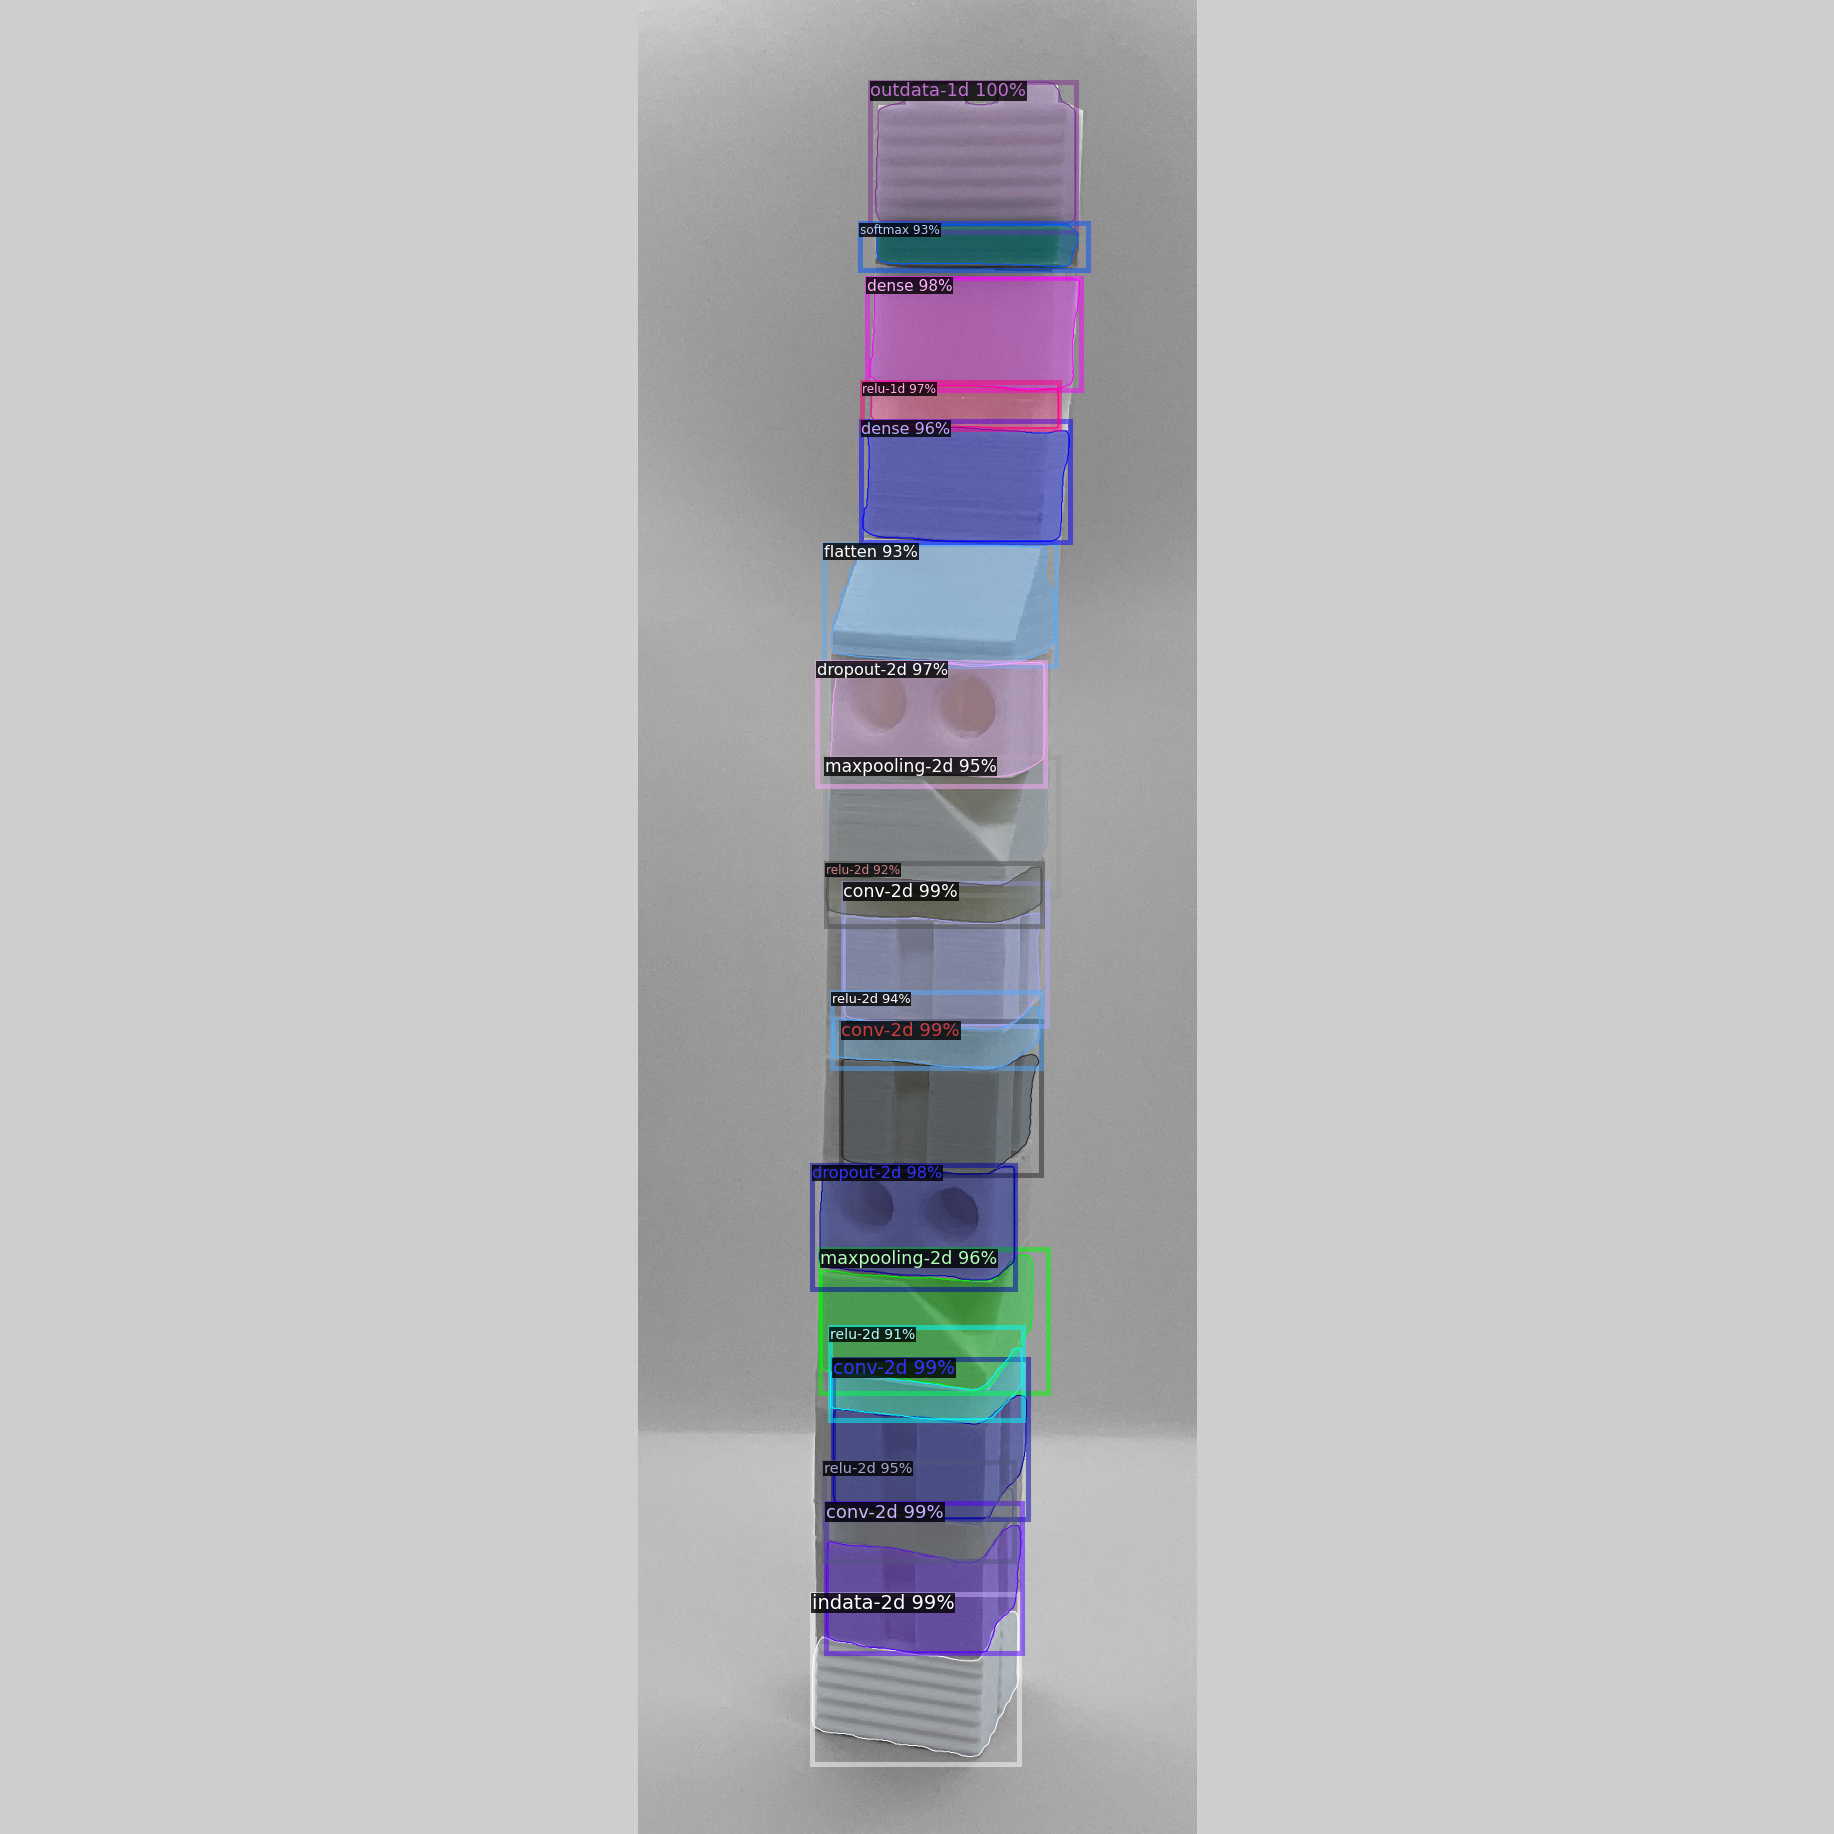

./trainable/test/11_75.jpg


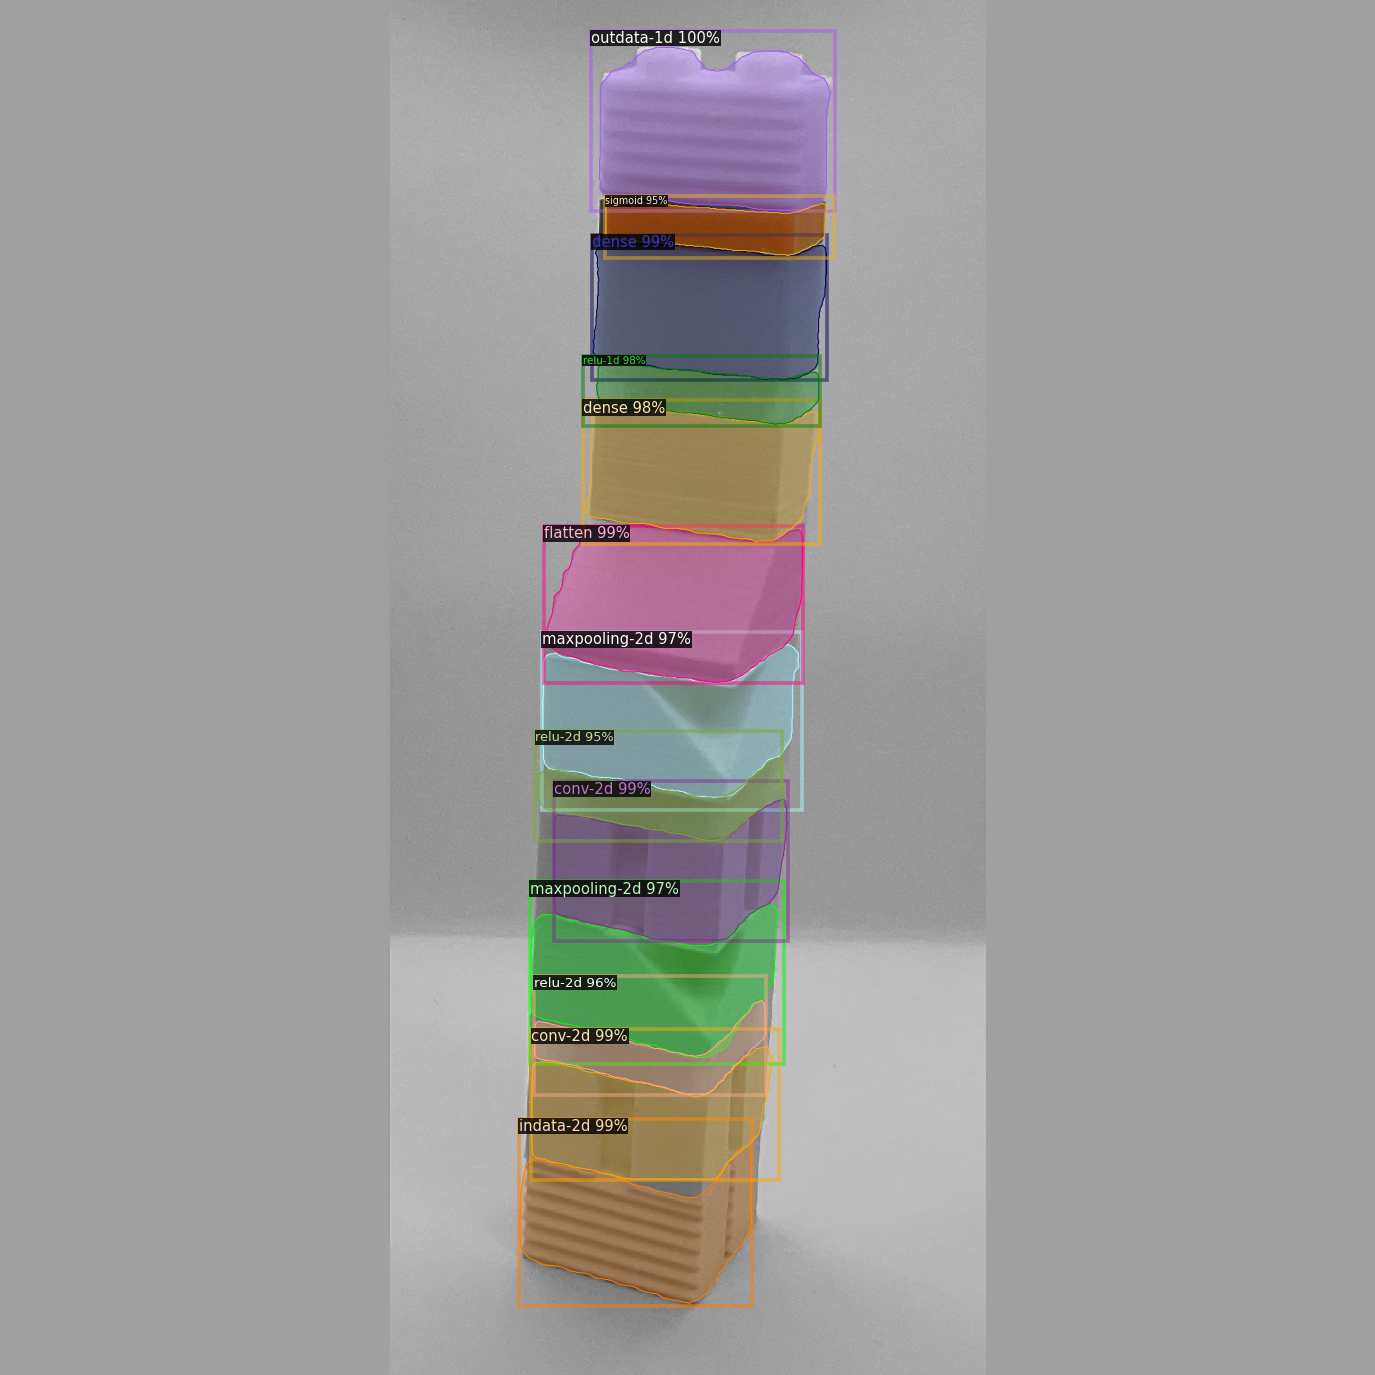

./trainable/test/7_75.jpg


In [22]:
from detectron2.utils.visualizer import ColorMode
# use validation images to get predictions inference
for d in random.sample(test_dataset, 3):
    print(d['file_name'])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.7, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [41]:
print(train_metadata)
print(test_metadata)

Metadata(evaluator_type='coco', image_root='./trainable/train', json_file='./trainable/train/train_set.json', name='deepbrick', thing_classes=['outdata-1d', 'softmax', 'dense', 'indata-1d', 'dropout-1d', 'relu-1d', 'sigmoid', 'flatten', 'embedding-short', 'dropout-2d', 'maxpooling-2d', 'relu-2d', 'conv-2d', 'indata-2d'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13})
Metadata(evaluator_type='coco', image_root='./trainable/test', json_file='./trainable/test/test_set.json', name='deepbrick_test', thing_classes=['outdata-1d', 'softmax', 'dense', 'indata-1d', 'dropout-1d', 'relu-1d', 'sigmoid', 'flatten', 'embedding-short', 'dropout-2d', 'maxpooling-2d', 'relu-2d', 'conv-2d', 'indata-2d'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13})


## Benchmark inference speed

In [20]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.10,fps:9.68
